ipynb to test ml training code before running
as python script

In [1]:
# Import TF and check for GPU

import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
print("TensorFlow version:", tf.__version__)

# Import required libraries

import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import save_model, load_model
import math
from sklearn.model_selection import train_test_split
import sys
import random 


2023-09-12 09:44:32.559602: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-12 09:44:33.525238: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/abraham/miniconda3/envs/tf/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.12.1


In [3]:
# Test whether GPU RAM is filled while
# using tf.data.Dataset.from_tensor_slices() method
# gfg = tf.data.Dataset.from_tensor_slices([1, 2, 3, 4, 5])
  
# for ele in gfg:
#     print(ele.numpy())
# Even for small dataset 30 GB of GPU is automatically filled

In [25]:
# 1. Load Dataset
## Load Train Set
train_shape_dir = '/home/abraham/Documents/ms_proj_shape_lc_gen/data_npy/shape_npy/shape_filled5.npy'
train_lc_dir = '/home/abraham/Documents/ms_proj_shape_lc_gen/data_npy/lc_npy/lc_dict_5.npy'
train_lc = np.load(train_lc_dir)
train_shape = np.load(train_shape_dir)
# Check equality of number of dataset
if len(train_lc)==len(train_shape):
    print("Train Set: No. of LC = No. of shapes")
else:
    sys.exit("EXIT: Train Set: No. of LC != No. of shapes")

## Load Validation Set
vald_shape_dir = '/home/abraham/Documents/ms_proj_shape_lc_gen/data_npy/shape_npy/shape_filled4.npy'
vald_lc_dir = '/home/abraham/Documents/ms_proj_shape_lc_gen/data_npy/lc_npy/lc_dict_4.npy'
vald_lc = np.load(vald_lc_dir)
vald_shape = np.load(vald_shape_dir)
# Check equality of number of dataset
if len(vald_lc)==len(vald_shape):
    print("Vald Set: No. of LC = No. of shapes")
else:
    sys.exit("Vald Set: No. of LC = No. of shapes")

Train Set: No. of LC = No. of shapes
Vald Set: No. of LC = No. of shapes


In [26]:
# 2. Normalize the image, convert to opacity map
## Train Set
train_shape = train_shape/np.amax(train_shape)
train_shape_where_0 = np.where(train_shape == 0)
train_shape_where_1 = np.where(train_shape == 1)
train_shape[train_shape_where_0] = 1  # 1 represent the shape (1 opacity)
train_shape[train_shape_where_1] = 0  # 0 represent background (0 opacity)

## Valdn Set
vald_shape = vald_shape/np.amax(vald_shape)
vald_shape_where_0 = np.where(vald_shape == 0)
vald_shape_where_1 = np.where(vald_shape == 1)
vald_shape[vald_shape_where_0] = 1  # 1 represent the shape (1 opacity)
vald_shape[vald_shape_where_1] = 0  # 0 represent background (0 opacity)
print("Normalized the shape")


Normalized the shape


In [27]:
# 2. Normalize the lightcurves
## - Train Set
train_lc_scaled = np.zeros(train_lc.shape)
for i in np.arange(len(train_lc_scaled)):
    train_lc_scaled[i] = (train_lc[i] - np.amin(train_lc[i]))/(np.amax(train_lc[i]) - np.amin(train_lc[i]))

## - Vald Set
vald_lc_scaled = np.zeros(vald_lc.shape)
for i in np.arange(len(vald_lc_scaled)):
    vald_lc_scaled[i] = (vald_lc[i] - np.amin(vald_lc[i]))/(np.amax(vald_lc[i]) - np.amin(vald_lc[i]))
print("Normalized the light curves")


Normalized the light curves


In [28]:
# Add flat line towards left and right of dip
# 50 data points on each side
# 3. Extend the lightcurves
## - Train Set
train_lc_scaled_append = np.ones((train_lc.shape[0],200))
print('train_lc_scaled_append.shape = ',train_lc_scaled_append.shape)
print("len(train_lc_scaled_append[0,50:150]) = ",len(train_lc_scaled_append[0,50:150]))

for i in np.arange(len(train_lc_scaled)):
    train_lc_scaled_append[i,50:150] = train_lc_scaled[i]

## - Vald Set
vald_lc_scaled_append = np.ones((vald_lc.shape[0],200))
for i in np.arange(len(vald_lc_scaled)):
    vald_lc_scaled_append[i,50:150] = vald_lc_scaled[i]
print("Extended the light curves")

train_lc_scaled_append.shape =  (132136, 200)
len(train_lc_scaled_append[0,50:150]) =  100
Extended the light curves


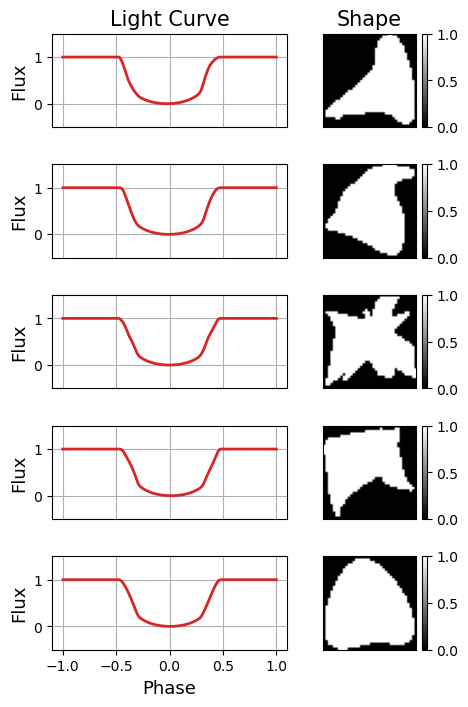

In [32]:
# Plot - Train LCs
num = 5
fig,ax=plt.subplots(num,2, figsize=(5,8), gridspec_kw={ 'width_ratios': [2,1],
        'wspace': 0.2,'hspace': 0.4})

ax[0][1].set_title('Shape',size=15)
ax[0][0].set_title('Light Curve',size=15)
ax[num-1][0].set_xlabel('Phase',size=13)
ph = np.linspace(-1,1,len(train_lc_scaled_append[0]))
# advance = 60

i = 0
for i in np.arange(0,num):
    k = random.randint(0, len(train_lc_scaled_append)-1)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][0].tick_params(labelbottom = False, bottom = False)
    img = ax[i][1].imshow(train_shape[k],cmap='gray')
    plt.colorbar(img)
    ax[i][0].set_ylabel('Flux',size=13)
    ax[i][0].set_ylim(-0.5,1.5)
#     ax[i][0].scatter(ph, vald_lc_scaled_append[k],color = 'black',marker='.')
    ax[i][0].plot(ph, train_lc_scaled_append[k],color = 'tab:red',linewidth='2')
    ax[i][0].grid('on')
    i = i + 1

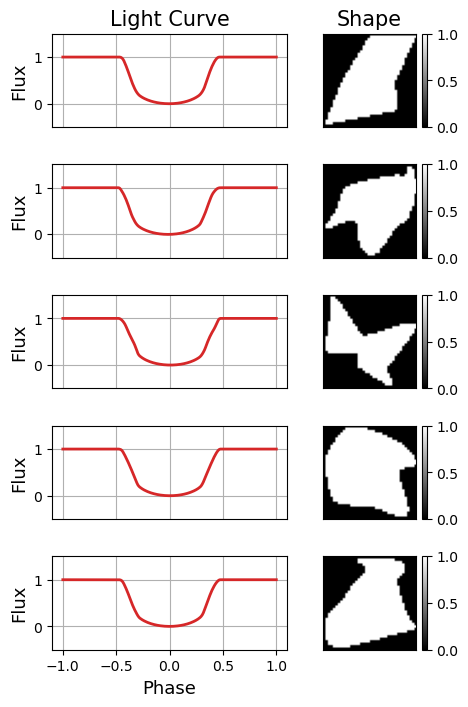

In [33]:
# Plot - Vald LCs
num = 5
fig,ax=plt.subplots(num,2, figsize=(5,8), gridspec_kw={ 'width_ratios': [2,1],
        'wspace': 0.2,'hspace': 0.4})

ax[0][1].set_title('Shape',size=15)
ax[0][0].set_title('Light Curve',size=15)
ax[num-1][0].set_xlabel('Phase',size=13)
ph = np.linspace(-1,1,len(vald_lc_scaled_append[0]))
# advance = 60

i = 0
for i in np.arange(0,num):
    k = random.randint(0, len(vald_lc_scaled_append)-1)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][0].tick_params(labelbottom = False, bottom = False)
    img = ax[i][1].imshow(vald_shape[k],cmap='gray')
    plt.colorbar(img)
    ax[i][0].set_ylabel('Flux',size=13)
    ax[i][0].set_ylim(-0.5,1.5)
#     ax[i][0].scatter(ph, vald_lc_scaled_append[k],color = 'black',marker='.')
    ax[i][0].plot(ph, vald_lc_scaled_append[k],color = 'tab:red',linewidth='2')
    ax[i][0].grid('on')
    i = i + 1

In [4]:
# Calculate the size (MB)
array_size_bytes = train_lc_scaled.nbytes

# Convert bytes to megabytes
array_size_mb = array_size_bytes / (1024 * 1024)

print("Size of the NumPy array (in MB):", array_size_mb)

Size of the NumPy array (in MB): 100.811767578125


In [34]:
# ML Pipeline
## Train Set
train_dataset = tf.data.Dataset.from_tensor_slices((train_lc_scaled_append, train_shape))
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(len(train_dataset))
train_dataset = train_dataset.batch(100)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
print(train_dataset)

## Vald Set
vald_dataset = tf.data.Dataset.from_tensor_slices((vald_lc_scaled_append, vald_shape))
vald_dataset = vald_dataset.batch(100)
vald_dataset = vald_dataset.cache()
vald_dataset = vald_dataset.prefetch(tf.data.AUTOTUNE)

print(vald_dataset)

2023-09-12 10:34:45.270590: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30931 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 200), dtype=tf.float64, name=None), TensorSpec(shape=(None, 38, 38), dtype=tf.float64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 200), dtype=tf.float64, name=None), TensorSpec(shape=(None, 38, 38), dtype=tf.float64, name=None))>


In [35]:
# CNN Model
input_shape = np.array(np.shape(train_lc_scaled_append[0]))
print("np.shape(input_shape) = ",input_shape[0])

output_shape = np.array(np.shape(train_shape[0]))
print("np.shape(input_shape) = ",output_shape[0],output_shape[1])

START = input_shape[0] # 94 #
END = output_shape[0] # 38  # pixel size along one axis
print("Start = ",START)
print("End = ",END)

conv_ip = keras.layers.Input(shape=(START,),name='Input')
x= keras.layers.Reshape((START, 1), input_shape=(START,),name='reshape_1')(conv_ip)
x= keras.layers.BatchNormalization()(x)

x=keras.layers.Conv1D(16,kernel_size=5,strides=1,activation='relu',name='conv16_5', padding='same')(x)
x=keras.layers.Conv1D(16,kernel_size=5,strides=1,activation='relu',name='second_conv16_5', padding='same')(x)
x=keras.layers.MaxPool1D(5,strides=2,data_format='channels_last',name='maxpool_1', padding='same')(x) #400

x=keras.layers.Conv1D(32,kernel_size=5,strides=1,activation='relu',name='first_conv32_5', padding='same')(x)
x=keras.layers.Conv1D(32,kernel_size=5,strides=1,activation='relu',name='second_conv32_5', padding='same')(x)
x=keras.layers.MaxPool1D(5,strides=2,data_format='channels_last',name='maxpool_2', padding='same')(x) #200

x=keras.layers.Conv1D(64,kernel_size=5,strides=1,activation='relu',name='first_conv64_5', padding='same')(x)
x=keras.layers.Conv1D(64,kernel_size=5,strides=1,activation='relu',name='second_conv64_5', padding='same')(x)
x=keras.layers.MaxPool1D(5,strides=2,data_format='channels_last',name='maxpool_3', padding='same')(x) #100

x=keras.layers.Flatten(name='flat_1')(x)

x2=keras.layers.Dense(256,name='dense_layer_5',activation='relu')(x)
x2=keras.layers.Dense(256,name='dense_layer_6',activation='relu')(x2)

x2= keras.layers.Dense(END**2,name='dense_layer_u',activation='relu')(x2)
x2 = keras.layers.Reshape(target_shape=(END, END, 1),name='reshape_2')(x2)

x2=keras.layers.Conv2D(32,kernel_size=(3,3),strides=1,activation='relu',name='second_conv64_52', padding='same')(x2)
x2=keras.layers.Conv2D(32,kernel_size=(3,3),strides=1,activation='relu',name='second_conv64_522', padding='same')(x2)
x2=keras.layers.Conv2D(16,kernel_size=(3,3),strides=1,activation='relu',name='second_conv64_524', padding='same')(x2)
x2=keras.layers.Conv2D(1,kernel_size=3,strides=1,activation='relu',name='second_conv64_53', padding='same')(x2)
conv_op = keras.layers.Reshape(target_shape=(END, END),name='reshape_3')(x2)
model = keras.Model(inputs=conv_ip, outputs=conv_op, name="predict_shape_from_LC")
model.summary()
print("Model is defined")

np.shape(input_shape) =  200
np.shape(input_shape) =  38 38
Start =  200
End =  38
Model: "predict_shape_from_LC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 200)]             0         
                                                                 
 reshape_1 (Reshape)         (None, 200, 1)            0         
                                                                 
 batch_normalization (BatchN  (None, 200, 1)           4         
 ormalization)                                                   
                                                                 
 conv16_5 (Conv1D)           (None, 200, 16)           96        
                                                                 
 second_conv16_5 (Conv1D)    (None, 200, 16)           1296      
                                                                 
 maxpool_1 (MaxPooling1D)   

In [36]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='mse')
print("Model is compiled")

#Patience early stopping
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
print("Early stopping defined")

#Learning rate scheduler
def step_decay(epoch):
	initial_lrate = 0.001
	drop = 0.5
	epochs_drop = 20
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate
lr_sched = keras.callbacks.LearningRateScheduler(step_decay)
print("Learning rate scheduler defined")

Model is compiled
Early stopping defined
Learning rate scheduler defined


In [37]:
# Training 
print("Training will start now")
# history = model.fit(train_lc_scaled, train_shape, epochs=2000,verbose=2, validation_data=(vald_lc_scaled,vald_shape),callbacks=[es,lr_sched])
history = model.fit(train_dataset, epochs=2000,verbose=2, validation_data=vald_dataset,callbacks=[es,lr_sched])

# Save Model
save_model(model, "ml_saved_models/model_sep12/model_sep12_v1_no_noise_lc.h5")

Training will start now
Epoch 1/2000


2023-09-12 10:35:19.889404: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [132136,38,38]
	 [[{{node Placeholder/_1}}]]
2023-09-12 10:35:19.889917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [132136,38,38]
	 [[{{node Placeholder/_1}}]]
2023-09-12 10:35:23.538029: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-09-12 10:35:25.070765: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fd4d32bd680 initialized for platform CUDA (this does not guarantee that XLA will be u

1322/1322 - 32s - loss: 0.1543 - val_loss: 0.1370 - lr: 0.0010 - 32s/epoch - 24ms/step
Epoch 2/2000
1322/1322 - 21s - loss: 0.1311 - val_loss: 0.1241 - lr: 0.0010 - 21s/epoch - 16ms/step
Epoch 3/2000
1322/1322 - 21s - loss: 0.1244 - val_loss: 0.1212 - lr: 0.0010 - 21s/epoch - 16ms/step
Epoch 4/2000
1322/1322 - 20s - loss: 0.1207 - val_loss: 0.1161 - lr: 0.0010 - 20s/epoch - 15ms/step
Epoch 5/2000
1322/1322 - 19s - loss: 0.1184 - val_loss: 0.1155 - lr: 0.0010 - 19s/epoch - 15ms/step
Epoch 6/2000
1322/1322 - 20s - loss: 0.1171 - val_loss: 0.1126 - lr: 0.0010 - 20s/epoch - 15ms/step
Epoch 7/2000
1322/1322 - 19s - loss: 0.1162 - val_loss: 0.1131 - lr: 0.0010 - 19s/epoch - 14ms/step
Epoch 8/2000
1322/1322 - 20s - loss: 0.1153 - val_loss: 0.1130 - lr: 0.0010 - 20s/epoch - 15ms/step
Epoch 9/2000
1322/1322 - 20s - loss: 0.1148 - val_loss: 0.1115 - lr: 0.0010 - 20s/epoch - 15ms/step
Epoch 10/2000
1322/1322 - 20s - loss: 0.1144 - val_loss: 0.1136 - lr: 0.0010 - 20s/epoch - 15ms/step
Epoch 11/200

In [8]:
# save_model(model, "ml_saved_models/model_sep7/model_sep7_v1_no_noise_lc_backup.h5")

In [40]:
# Validation dataset - Prediciton
model_load = load_model('ml_saved_models/model_sep12/model_sep12_v1_no_noise_lc.h5')
vald_predict_shape = model_load.predict(vald_lc_scaled_append)

32/32 [==============================] - 1s 8ms/step


In [ ]:
vald_predict_shape

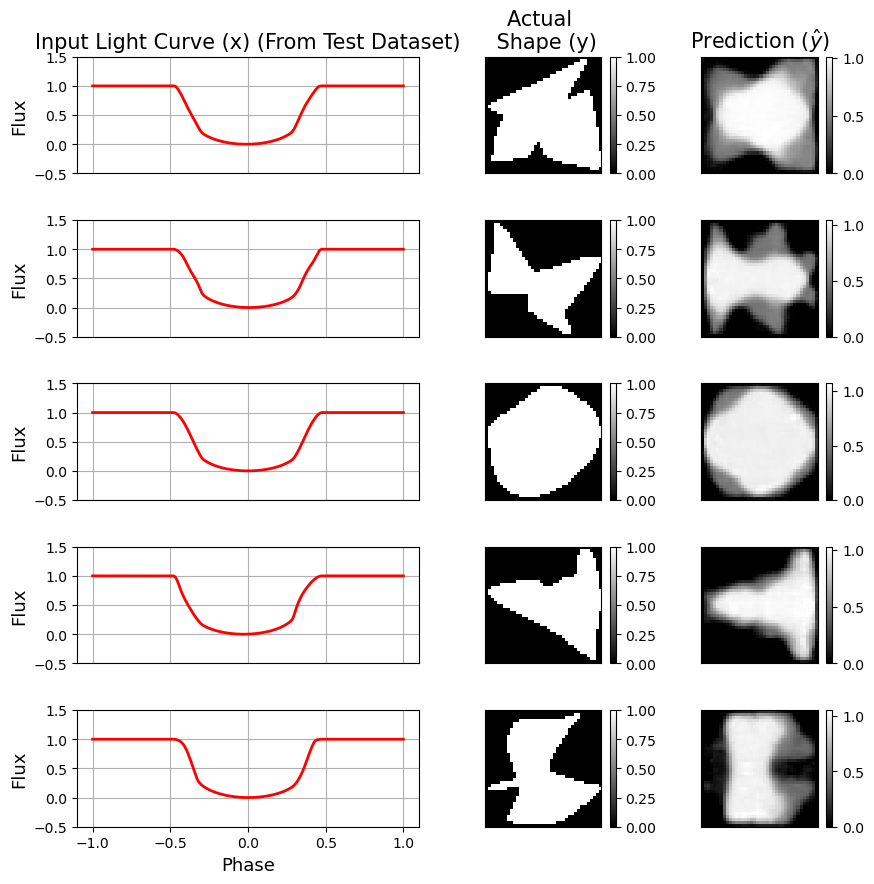

In [43]:
num = 5
fig,ax=plt.subplots(num,3, figsize=(10,10), gridspec_kw={ 'width_ratios': [2,1,1],
        'wspace': 0.2,'hspace': 0.4})

ax[0][1].set_title('Actual \n Shape (y)',size=15)
ax[0][0].set_title('Input Light Curve (x) (From Test Dataset)',size=15)
ax[0][2].set_title(r'Prediction ($\hat{y}$)',size=15)
ax[num-1][0].set_xlabel('Phase',size=13)
ph = np.linspace(-1.0,1.0,len(vald_lc_scaled_append[0]))
# advance = 60
for i in range(num):
    k = random.randint(0, len(vald_lc_scaled_append)-1)
    ax[i][2].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][0].tick_params(labelbottom = False, bottom = False)
    img = ax[i][1].imshow(vald_shape[k],cmap='gray')
    plt.colorbar(img)
    ax[i][0].set_ylabel('Flux',size=13)
    ax[i][0].set_ylim(-0.5,1.5)
    ax[i][0].plot(ph, vald_lc_scaled_append[k],color = 'red',linewidth=2)
    img = ax[i][2].imshow(vald_predict_shape[k],cmap='gray')
    ax[i][0].grid('on')
    plt.colorbar(img)

In [44]:
# Load the test Dataset
test_shape_dir = '/home/abraham/Documents/ms_proj_shape_lc_gen/data_npy/shape_npy/shape_filled8.npy'
test_lc_dir = '/home/abraham/Documents/ms_proj_shape_lc_gen/data_npy/lc_npy/lc_dict_8.npy'
test_lc = np.load(test_lc_dir)
test_shape = np.load(test_shape_dir)
# Check equality of number of dataset
if len(test_lc)==len(test_shape):
    print("test Set: No. of LC = No. of shapes")
else:
    sys.exit("EXIT: testn Set: No. of LC != No. of shapes")

# Normalize the image, convert to opacity map
## Test Set
test_shape = test_shape/np.amax(test_shape)
test_shape_where_0 = np.where(test_shape == 0)
test_shape_where_1 = np.where(test_shape == 1)
test_shape[test_shape_where_0] = 1  # 1 represent the shape (1 opacity)
test_shape[test_shape_where_1] = 0  # 0 represent background (0 opacity)


# Normalize the lightcurves
## - Test Set
test_lc_scaled = np.zeros(test_lc.shape)
for i in np.arange(len(test_lc_scaled)):
    test_lc_scaled[i] = (test_lc[i] - np.amin(test_lc[i]))/(np.amax(test_lc[i]) - np.amin(test_lc[i]))



test Set: No. of LC = No. of shapes


In [60]:
## - Test Set
test_lc_scaled_append = np.ones((test_lc.shape[0],200))
for i in np.arange(len(test_lc_scaled)):
    test_lc_scaled_append[i,50:150] = test_lc_scaled[i]
print("Extended the light curves")

Extended the light curves


In [61]:
# Test dataset - Prediciton
model_load = load_model('ml_saved_models/model_sep12/model_sep12_v1_no_noise_lc.h5')
test_predict_shape = model_load.predict(test_lc_scaled_append)

8/8 [==============================] - 0s 5ms/step


In [63]:
test_predict_shape_normalized = np.zeros(test_predict_shape.shape)
for i in np.arange(len(test_predict_shape)):
    test_predict_shape_normalized[i] = (test_predict_shape[i] - np.amin(test_predict_shape[i]))/(np.amax(test_predict_shape[i]) - np.amin(test_predict_shape[i]))
print("Normalized the predicted shape")

Normalized the predicted shape


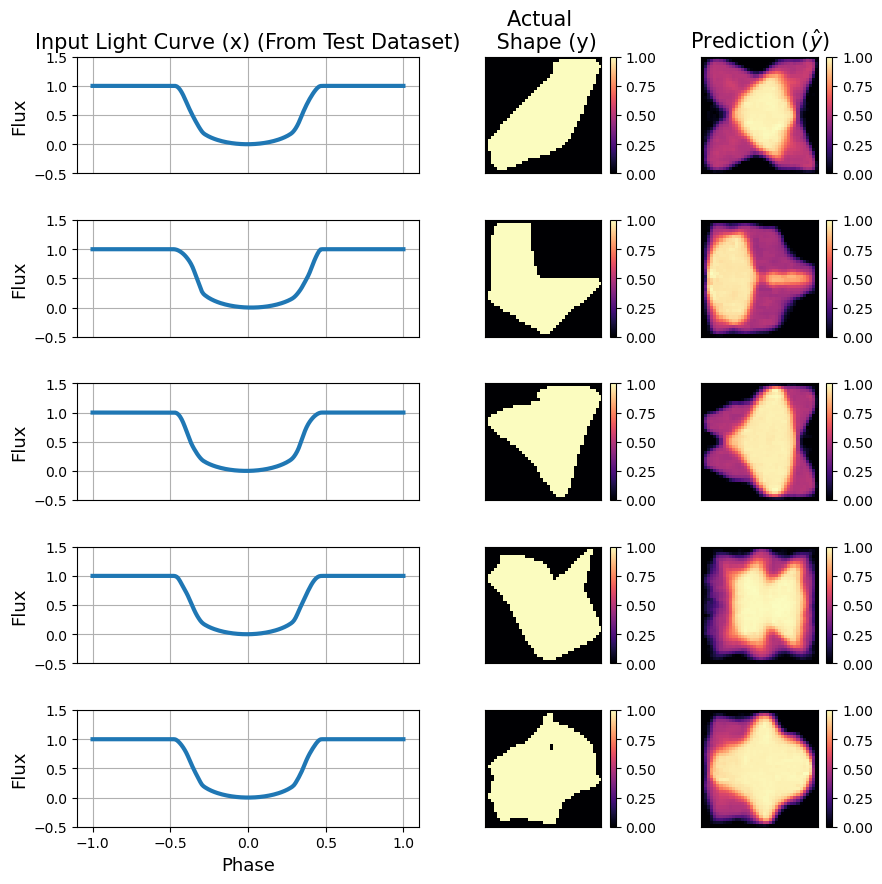

In [64]:
num = 5
fig,ax=plt.subplots(num,3, figsize=(10,10), gridspec_kw={ 'width_ratios': [2,1,1],
        'wspace': 0.2,'hspace': 0.4})

ax[0][1].set_title('Actual \n Shape (y)',size=15)
ax[0][0].set_title('Input Light Curve (x) (From Test Dataset)',size=15)
ax[0][2].set_title(r'Prediction ($\hat{y}$)',size=15)
ax[num-1][0].set_xlabel('Phase',size=13)
ph = np.linspace(-1.0,1.0,len(test_lc_scaled_append[0]))
# advance = 60
for i in range(num):
    k = random.randint(0, len(test_lc_scaled_append)-1) # 220 + i # 
    ax[i][2].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][0].tick_params(labelbottom = False, bottom = False)
    img = ax[i][1].imshow(test_shape[k],cmap='magma')
    plt.colorbar(img)
    ax[i][0].set_ylabel('Flux',size=13)
    ax[i][0].set_ylim(-0.5,1.5)
    ax[i][0].plot(ph, test_lc_scaled_append[k],color = 'tab:blue',linewidth=3)
    img = ax[i][2].imshow(test_predict_shape_normalized[k],cmap='magma')
    ax[i][0].grid('on')
    plt.colorbar(img)